In [1]:
import os
import requests
import uuid
from io import BytesIO
import numpy as np
import pandas as pd
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

from sklearn.neighbors import NearestNeighbors

import tensorflow as tf
from keras.models import Model
from keras import layers
from keras.regularizers import l2

import matplotlib.pyplot as plt
import hashlib
import logging

# Configuración de logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("smote_process.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

print(f'tensorflow: {tf.__version__}')
print(f'keras: {tf.keras.__version__}')

tensorflow: 2.17.0
keras: 3.6.0


In [2]:
# 1. Configuración inicial
LOCAL_IMAGE_PATH = './repo_dataset'
TARGET_SIZE = (224, 224)
TARGET_SIZE_CHANNEL = (224, 224, 3)
BATCH_SIZE = 32

# Columnas de clases
LABEL_COLUMNS = ['direccion', 'fachada', 'envio', 'etiqueta']

#cargar csv y dividir en dev set y test set
# Load the dataset into a DataFrame
#CSV_PATH = '.\mobilnet-multi-label-solo-local.csv'
#CSV_PATH = '.\mobilnet-multi-label.csv'
#CSV_PATH = '.\mobilnet-multi-label-dev-test-50.csv'
CSV_PATH = '.\mobilnet-multi-label-train-80.csv'
CSV_PATH_DEV = '.\mobilnet-multi-label-dev-test-50.csv'
CSV_PATH_TEST = '.\mobilnet-multi-label-test-50.csv'

CSV_TRAIN = CSV_PATH_DEV

In [3]:
# cargar las imagenes
def prepare_image(row, local_image_path, label_columns, target_size):
    # Preparar las etiquetas
    labels = row[label_columns].values.astype(int)
 
    try:
        # Cargar desde archivo local
        img_path = os.path.join(local_image_path, row['filename'])
        if os.path.exists(img_path):
            image = Image.open(img_path)
        elif pd.notna(row['urlAbsoluta']):    
             urlAbsoluta = row['urlAbsoluta']
             if 'http' in urlAbsoluta:
                 # Descargar la imagen desde la URL
                 response = requests.get(row['urlAbsoluta'], stream=True, timeout=10)
                 if response.status_code == 200:
                     image = Image.open(BytesIO(response.content))
                     #guardar local para el siguiente ciclo de entrenamiento/prueba
                     image.save(img_path)
             elif os.path.exists(urlAbsoluta):
                 image = Image.open(urlAbsoluta)
             else:
                 raise Exception(f'Error cargando {urlAbsoluta}, archivo no encontrado')
    
        # Convertir a RGB (en caso de que la imagen esté en otro formato, como RGBA)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        # Redimensionar la imagen
        image = image.resize(target_size)  # Redimensionar a 224x224 para MobileNetV3
        
        # Convertir a un array de numpy y normalizar
        image = np.array(image) / 255.0  # Normalizar
        
        return image, np.array(labels)
    except BaseException as e:
        print(f'Error en: {img_path}, Excepción: {str(e)}')
        return None

def print_class_distribution(X, y, label_columns):
    print(f"Dataset preparado con {len(X)} imágenes")
    print(f"Distribución de clases:")
    for i, col in enumerate(label_columns):
        positive_samples = np.sum(y[:, i])
        percentage = (positive_samples / len(y)) * 100
        print(f"{col}: {percentage:.2f}% ({int(positive_samples)}/{len(y)})")


def print_class_distribution_from_csv(csv_path, label_columns):
    """
    Imprime la distribución de clases leyendo desde un archivo CSV
    
    Parámetros:
    csv_path: str - Ruta al archivo CSV
    label_columns: list - Lista de nombres de las columnas de etiquetas
    """
    # Leer solo las columnas necesarias del CSV
    df = pd.read_csv(csv_path, usecols=label_columns)
    total_samples = len(df)
    frecuencias = [0] * len(label_columns)
    
    print(f"Dataset preparado con {total_samples} imágenes")
    print(f"Distribución de clases:")
    
    for idx, col in enumerate(label_columns):
        positive_samples = df[col].sum()
        percentage = (positive_samples / total_samples) * 100
        print(f"{col}: {percentage:.2f}% ({int(positive_samples)}/{total_samples})")
        frecuencias[idx] = positive_samples
    return total_samples, frecuencias

In [4]:
# 1. Data Augmentation para robustecer el entrenamiento
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

def build_model(num_classes):
    # 1. Cargar el modelo base pre-entrenado (MobileNetV3Large) sin la capa de clasificación final
    base_model = tf.keras.applications.MobileNetV3Large(
        input_shape=TARGET_SIZE_CHANNEL,
        include_preprocessing=False, # las imagnes de entrada estan normalizadas [0,1] y el modelo espera [0,255]
        include_top=False,  # Excluimos la parte de clasificación original
        weights='imagenet'
    )
    base_model.trainable = False

    # Construir la nueva arquitectura agregando una cabeza de clasificación para multi-label
    inputs = tf.keras.Input(shape=TARGET_SIZE_CHANNEL)
    # Aplicar data augmentation PRIMERO (en [0,1])
    x = data_augmentation(inputs)
    
    # Luego normalizar a [-1,1]
    x = layers.Rescaling(scale=2.0, offset=-1.0)(x)  # Mapea [0,1] a [-1,1]

    # Pasar por la base pre-entrenada (no se necesita rescaling adicional)
    x = base_model(x, training=False)  # training=False mantiene fijos los parámetros de BatchNorm
    
    # Utilizar GlobalAveragePooling2D para aplanar la salida del base model
    x = layers.GlobalAveragePooling2D()(x)

    # Agregar capa densa con regularización L2, BatchNormalization y Dropout
    x = layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Capa de salida para multi-label con activación sigmoide
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)

    return Model(inputs, outputs)

In [5]:
# Función para graficar las métricas de entrenamiento y validación
def plot_training_history(history):
   # metrics = ['binary_accuracy', 'precision', 'recall']
    metrics = ['f1_macro', 'f1_micro']
    plt.figure(figsize=(18, 5))
    
    for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i + 1)
        plt.plot(history.history[metric], label='Entrenamiento')
        plt.plot(history.history['val_' + metric], label='Validación')
        plt.title(metric.capitalize())
        plt.xlabel('Épocas')
        plt.ylabel(metric)
        plt.legend()
    
    plt.tight_layout()
    plt.show()

In [4]:
# calcular frecuencias de las clases del set de entrenamiento antes de smote
def print_class_distribution_from_csv_no_SMOTE(csv_path, label_columns):
    """
    Imprime la distribución de clases leyendo desde un archivo CSV
    
    Parámetros:
    csv_path: str - Ruta al archivo CSV
    label_columns: list - Lista de nombres de las columnas de etiquetas
    """
    # Leer solo las columnas necesarias del CSV
    df = pd.read_csv(csv_path)
    df = df[df['filename'].str.startswith('synth_')==False]
    total_samples = len(df)
    frecuencias = [0] * len(label_columns)
    
    print(f"Dataset preparado con {total_samples} imágenes sin SOMTE")
    print(f"Distribución de clases sin SMOTE:")
    
    for idx, col in enumerate(label_columns):
        positive_samples = df[col].sum()
        percentage = (positive_samples / total_samples) * 100
        print(f"{col}: {percentage:.2f}% ({int(positive_samples)}/{total_samples})")
        frecuencias[idx] = positive_samples
    return total_samples, frecuencias

total_samples, frecuencias = print_class_distribution_from_csv_no_SMOTE(CSV_TRAIN, LABEL_COLUMNS)
print(total_samples, frecuencias)
alpha = [n / total_samples for n in frecuencias]  
alpha = [1 - n for n in alpha]  
print(f'frecuencia={frecuencias}, alpha={alpha}')


Dataset preparado con 2823 imágenes sin SOMTE
Distribución de clases sin SMOTE:
direccion: 21.50% (607/2823)
fachada: 23.17% (654/2823)
envio: 65.60% (1852/2823)
etiqueta: 50.16% (1416/2823)
2823 [607, 654, 1852, 1416]
frecuencia=[607, 654, 1852, 1416], alpha=[0.7849805171803046, 0.7683315621679065, 0.3439603258944386, 0.4984059511158342]


In [3]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', threshold=0.5, **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Aplicamos el umbral a las predicciones
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        tp = tf.reduce_sum(y_true * y_pred)
        fp = tf.reduce_sum((1 - y_true) * y_pred)
        fn = tf.reduce_sum(y_true * (1 - y_pred))
        
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)
    
    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    
    def reset_state(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)


class F1ScoreMacro(tf.keras.metrics.Metric):
    def __init__(self, num_classes, threshold=0.5, name='f1_macro', **kwargs):
        super(F1ScoreMacro, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.threshold = threshold
        self.f1_per_class = [F1Score(threshold=threshold) for _ in range(num_classes)]

    def update_state(self, y_true, y_pred, sample_weight=None):
        for i in range(self.num_classes):
            self.f1_per_class[i].update_state(y_true[:, i], y_pred[:, i], sample_weight)

    def result(self):
        return tf.reduce_mean([f1.result() for f1 in self.f1_per_class])

    def reset_state(self):
        for f1 in self.f1_per_class:
            f1.reset_state()

class F1ScoreMicro(tf.keras.metrics.Metric):
    def __init__(self, threshold=0.5, name='f1_micro', **kwargs):
        super(F1ScoreMicro, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        self.true_positives.assign_add(tf.reduce_sum(y_true * y_pred))
        self.false_positives.assign_add(tf.reduce_sum((1 - y_true) * y_pred))
        self.false_negatives.assign_add(tf.reduce_sum(y_true * (1 - y_pred)))

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

    def reset_state(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)


In [5]:
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, batch_size, img_size, local_image_path, label_columns, shuffle=True):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.dataframe))
        self.on_epoch_end()
        self.local_image_path = local_image_path
        self.label_columns = label_columns
        
    def __len__(self):
        return int(np.ceil(len(self.dataframe) / self.batch_size))
    
    def __getitem__(self, index):
        start = index * self.batch_size
        end = min((index + 1) * self.batch_size, len(self.dataframe))
        batch_indices = self.indices[start:end]
        batch_data = self.dataframe.iloc[batch_indices]
        
        images = []
        labels = []
        
        for _, row in batch_data.iterrows():
            result = prepare_image(row, self.local_image_path, self.label_columns, self.img_size)
            # Ya sabemos que prepare_image debería retornar datos válidos porque se filtró
            if result is not None:
                img, label = result
                images.append(img)
                labels.append(label)
            else:
                print('Omitiendo imagen inesperadamente:', row['filename'])
                continue
        
        X, y = np.array(images), np.array(labels)        
        return X, y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


In [8]:
from tensorflow.keras.utils import Sequence

class KFoldDataGenerator(Sequence):
    def __init__(self, file_paths, labels, batch_size=32, shuffle=True):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        # Usamos ceil para cubrir todos los ejemplos, incluso si el total no es múltiplo exacto de batch_size
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.file_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        # Índices del batch actual
        batch_indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

        images = []
        labels_batch = []
        for i in batch_indexes:
            columnas = ['filename', 'urlAbsoluta', 'direccion', 'fachada', 'envio', 'etiqueta']
            df = pd.DataFrame(columns=columnas)
            new_row = {
                'filename': self.file_paths[i],
                'urlAbsoluta': '',
                'direccion': self.labels[i][0],
                'fachada': self.labels[i][1],
                'envio': self.labels[i][2],
                'etiqueta': self.labels[i][3]
            }
            df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
            ultima_fila = df.loc[len(df) - 1]
            result = prepare_image(ultima_fila, LOCAL_IMAGE_PATH, LABEL_COLUMNS, TARGET_SIZE)

            if result is not None:
                image, _ = result
                images.append(image)
                labels_batch.append(self.labels[i])
            else: 
                continue
        
        # Convertir la lista de imágenes a un tensor (batch, 224, 224, 3)
        X = tf.stack(images)
        Y = tf.convert_to_tensor(labels_batch, dtype=tf.float32)
        return X, Y

Número de muestras: 2808
Shape de etiquetas: (2808, 4)
loss...
loss OK

===== Fold 1 / 5 =====
Fase 1: Entrenamiento con base congelada
Epoch 1/5


2025-02-23 13:56:20,881 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 13:56:20,927 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 13:56:20,974 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 13:56:21,011 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 13:56:21,407 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-02-23 13:56:21,545 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 13:56:21,590 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 13:56:21,620 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 13:56:21,668 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 13:56:21,911 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-02-23 13:56:24,640 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 13:56:24,679 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 13:56:24,727 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 13:56:24,763 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 13:56:25,105 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-02-23 13:56:25,219 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 13:56:25,270 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 13:56:25,325 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 13:56:25,362 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 13:56:25,586 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


71/71 [==============================] - 213s 3s/step - loss: 0.5933 - f1_macro: 0.7273 - f1_micro: 0.7727 - val_loss: 0.4933 - val_f1_macro: 0.8121 - val_f1_micro: 0.8382
Epoch 2/5
71/71 [==============================] - 183s 3s/step - loss: 0.4392 - f1_macro: 0.8070 - f1_micro: 0.8442 - val_loss: 0.4010 - val_f1_macro: 0.8376 - val_f1_micro: 0.8626
Epoch 3/5
71/71 [==============================] - 203s 3s/step - loss: 0.3682 - f1_macro: 0.8333 - f1_micro: 0.8637 - val_loss: 0.3730 - val_f1_macro: 0.8565 - val_f1_micro: 0.8770
Epoch 4/5
71/71 [==============================] - 189s 3s/step - loss: 0.3149 - f1_macro: 0.8408 - f1_micro: 0.8752 - val_loss: 0.3103 - val_f1_macro: 0.8600 - val_f1_micro: 0.8803
Epoch 5/5
71/71 [==============================] - 174s 2s/step - loss: 0.2687 - f1_macro: 0.8596 - f1_micro: 0.8854 - val_loss: 0.2653 - val_f1_macro: 0.8423 - val_f1_micro: 0.8766
Fase 2: Fine-tuning descongelando las últimas 20 capas
Epoch 1/5


2025-02-23 14:12:26,399 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 14:12:26,448 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 14:12:26,494 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 14:12:26,530 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 14:12:26,850 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-02-23 14:12:27,010 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 14:12:27,048 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 14:12:27,085 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 14:12:27,123 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 14:12:27,340 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-02-23 14:12:29,857 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 14:12:29,905 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 14:12:29,937 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 14:12:29,969 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 14:12:30,300 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-02-23 14:12:30,443 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 14:12:30,475 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 14:12:30,523 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 14:12:30,555 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 14:12:30,777 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


71/71 [==============================] - 184s 2s/step - loss: 0.2471 - f1_macro: 0.8502 - f1_micro: 0.8825 - val_loss: 0.2594 - val_f1_macro: 0.8590 - val_f1_micro: 0.8831
Epoch 2/5
71/71 [==============================] - 176s 2s/step - loss: 0.2435 - f1_macro: 0.8532 - f1_micro: 0.8863 - val_loss: 0.2571 - val_f1_macro: 0.8600 - val_f1_micro: 0.8822
Epoch 3/5
71/71 [==============================] - 176s 2s/step - loss: 0.2416 - f1_macro: 0.8533 - f1_micro: 0.8850 - val_loss: 0.2553 - val_f1_macro: 0.8624 - val_f1_micro: 0.8829
Epoch 4/5
71/71 [==============================] - 174s 2s/step - loss: 0.2391 - f1_macro: 0.8534 - f1_micro: 0.8838 - val_loss: 0.2540 - val_f1_macro: 0.8624 - val_f1_micro: 0.8830
Epoch 5/5
71/71 [==============================] - 176s 2s/step - loss: 0.2350 - f1_macro: 0.8597 - f1_micro: 0.8894 - val_loss: 0.2521 - val_f1_macro: 0.8629 - val_f1_micro: 0.8837
Resultados fold 1: ['loss', 'f1_macro', 'f1_micro'] = [0.2521480619907379, 0.8629379272460938, 0.883

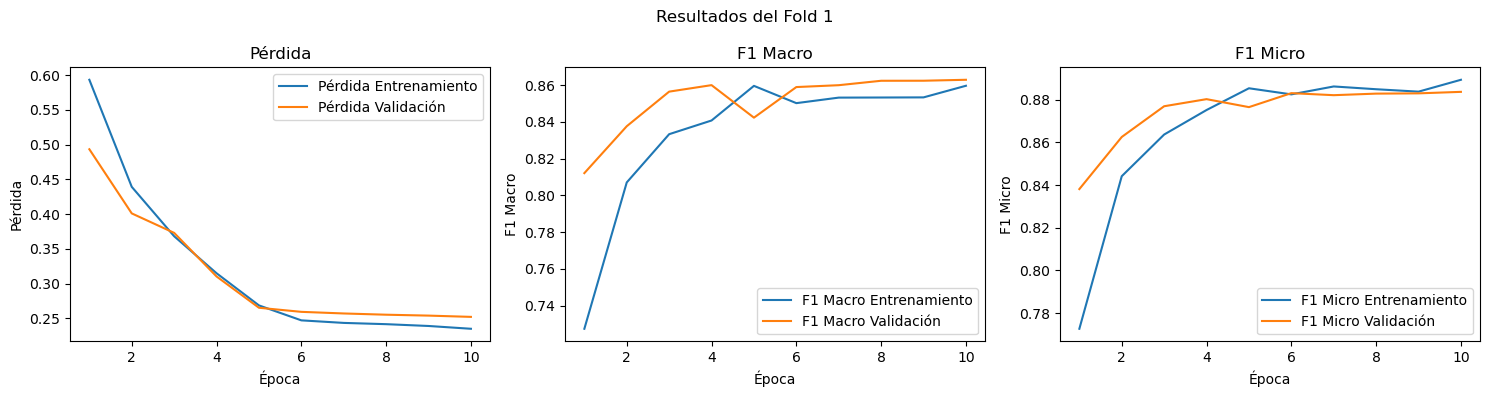


===== Fold 2 / 5 =====
Fase 1: Entrenamiento con base congelada
Epoch 1/5


2025-02-23 14:27:52,929 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 14:27:52,961 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 14:27:53,014 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 14:27:53,397 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 14:27:53,714 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-02-23 14:27:53,841 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 14:27:53,890 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 14:27:53,937 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 14:27:53,988 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 14:27:54,216 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-02-23 14:27:56,517 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 14:27:56,566 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 14:27:56,597 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 14:27:56,645 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 14:27:56,964 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-02-23 14:27:57,143 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 14:27:57,176 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 14:27:57,224 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 14:27:57,257 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 14:27:57,479 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


71/71 [==============================] - 182s 2s/step - loss: 0.5282 - f1_macro: 0.7897 - f1_micro: 0.8248 - val_loss: 0.4032 - val_f1_macro: 0.8550 - val_f1_micro: 0.8829
Epoch 2/5
71/71 [==============================] - 174s 2s/step - loss: 0.3140 - f1_macro: 0.8304 - f1_micro: 0.8656 - val_loss: 0.2590 - val_f1_macro: 0.8722 - val_f1_micro: 0.8977
Epoch 3/5
71/71 [==============================] - 172s 2s/step - loss: 0.2287 - f1_macro: 0.8454 - f1_micro: 0.8738 - val_loss: 0.1961 - val_f1_macro: 0.8430 - val_f1_micro: 0.8826
Epoch 4/5
71/71 [==============================] - 174s 2s/step - loss: 0.1817 - f1_macro: 0.8433 - f1_micro: 0.8771 - val_loss: 0.1569 - val_f1_macro: 0.8731 - val_f1_micro: 0.8984
Epoch 5/5
71/71 [==============================] - 173s 2s/step - loss: 0.1496 - f1_macro: 0.8584 - f1_micro: 0.8855 - val_loss: 0.1363 - val_f1_macro: 0.8158 - val_f1_micro: 0.8763
Fase 2: Fine-tuning descongelando las últimas 20 capas
Epoch 1/5


2025-02-23 14:42:30,477 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 14:42:30,525 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 14:42:30,558 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 14:42:30,588 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 14:42:30,913 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-02-23 14:42:31,044 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 14:42:31,065 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 14:42:31,114 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 14:42:31,144 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 14:42:31,350 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-02-23 14:42:34,065 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 14:42:34,096 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 14:42:34,144 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 14:42:34,176 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 14:42:34,479 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-02-23 14:42:34,607 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 14:42:34,639 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 14:42:34,687 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 14:42:34,724 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 14:42:34,927 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


71/71 [==============================] - 186s 3s/step - loss: 0.1348 - f1_macro: 0.8446 - f1_micro: 0.8802 - val_loss: 0.1295 - val_f1_macro: 0.8659 - val_f1_micro: 0.8987
Epoch 2/5
71/71 [==============================] - 174s 2s/step - loss: 0.1325 - f1_macro: 0.8651 - f1_micro: 0.8909 - val_loss: 0.1282 - val_f1_macro: 0.8718 - val_f1_micro: 0.9023
Epoch 3/5
71/71 [==============================] - 177s 3s/step - loss: 0.1298 - f1_macro: 0.8681 - f1_micro: 0.8938 - val_loss: 0.1274 - val_f1_macro: 0.8698 - val_f1_micro: 0.9019
Epoch 4/5
71/71 [==============================] - 175s 2s/step - loss: 0.1273 - f1_macro: 0.8719 - f1_micro: 0.8956 - val_loss: 0.1267 - val_f1_macro: 0.8753 - val_f1_micro: 0.9046
Epoch 5/5
71/71 [==============================] - 178s 3s/step - loss: 0.1273 - f1_macro: 0.8629 - f1_micro: 0.8908 - val_loss: 0.1260 - val_f1_macro: 0.8780 - val_f1_micro: 0.9068
Resultados fold 2: ['loss', 'f1_macro', 'f1_micro'] = [0.12604551017284393, 0.8780111074447632, 0.90

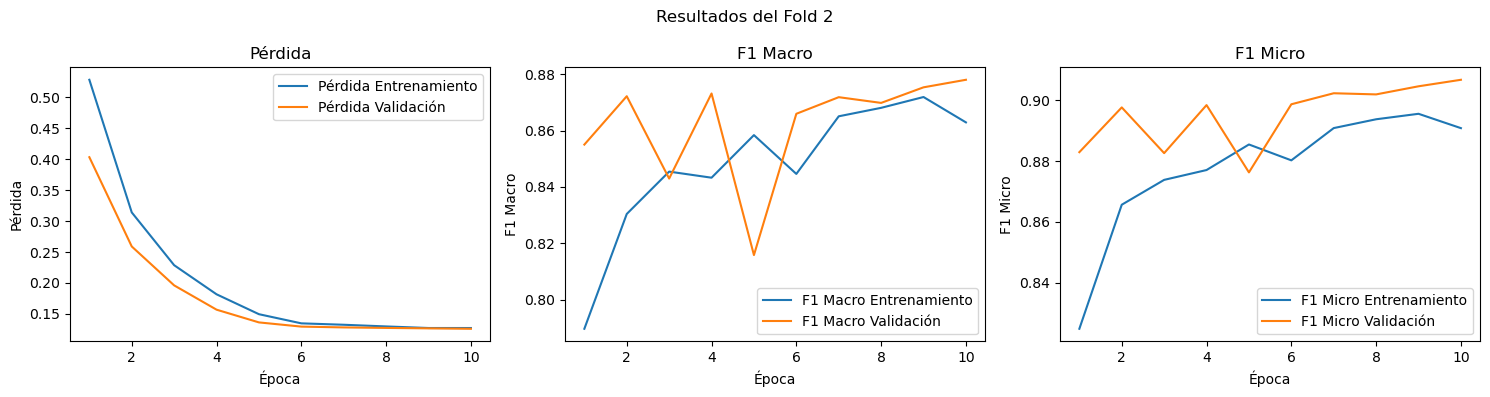


===== Fold 3 / 5 =====
Fase 1: Entrenamiento con base congelada
Epoch 1/5


2025-02-23 14:57:59,527 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 14:57:59,565 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 14:57:59,614 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 14:57:59,649 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 14:57:59,999 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-02-23 14:58:00,144 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 14:58:00,192 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 14:58:00,248 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 14:58:00,289 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 14:58:00,507 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-02-23 14:58:02,939 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 14:58:02,996 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 14:58:03,040 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 14:58:03,069 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 14:58:03,388 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-02-23 14:58:03,512 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 14:58:03,561 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 14:58:03,605 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 14:58:03,642 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 14:58:03,904 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


71/71 [==============================] - 185s 2s/step - loss: 0.5105 - f1_macro: 0.7943 - f1_micro: 0.8326 - val_loss: 0.4148 - val_f1_macro: 0.8180 - val_f1_micro: 0.8502
Epoch 2/5
71/71 [==============================] - 174s 2s/step - loss: 0.2828 - f1_macro: 0.8374 - f1_micro: 0.8660 - val_loss: 0.2302 - val_f1_macro: 0.8712 - val_f1_micro: 0.8907
Epoch 3/5
71/71 [==============================] - 172s 2s/step - loss: 0.1902 - f1_macro: 0.8457 - f1_micro: 0.8746 - val_loss: 0.1633 - val_f1_macro: 0.8607 - val_f1_micro: 0.8943
Epoch 4/5
71/71 [==============================] - 172s 2s/step - loss: 0.1489 - f1_macro: 0.8493 - f1_micro: 0.8782 - val_loss: 0.1320 - val_f1_macro: 0.8619 - val_f1_micro: 0.8897
Epoch 5/5
71/71 [==============================] - 173s 2s/step - loss: 0.1278 - f1_macro: 0.8530 - f1_micro: 0.8819 - val_loss: 0.1173 - val_f1_macro: 0.8735 - val_f1_micro: 0.8987
Fase 2: Fine-tuning descongelando las últimas 20 capas
Epoch 1/5


2025-02-23 15:12:38,826 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 15:12:38,884 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 15:12:38,946 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 15:12:38,991 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 15:12:39,317 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-02-23 15:12:39,478 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 15:12:39,524 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 15:12:39,588 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 15:12:39,641 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 15:12:39,857 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-02-23 15:12:42,727 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 15:12:42,783 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 15:12:42,833 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 15:12:42,890 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 15:12:43,301 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-02-23 15:12:43,445 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 15:12:43,491 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 15:12:43,537 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 15:12:43,578 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 15:12:43,821 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


71/71 [==============================] - 186s 3s/step - loss: 0.1128 - f1_macro: 0.8679 - f1_micro: 0.8932 - val_loss: 0.1106 - val_f1_macro: 0.8837 - val_f1_micro: 0.9068
Epoch 2/5
71/71 [==============================] - 176s 2s/step - loss: 0.1110 - f1_macro: 0.8647 - f1_micro: 0.8909 - val_loss: 0.1099 - val_f1_macro: 0.8846 - val_f1_micro: 0.9066
Epoch 3/5
71/71 [==============================] - 176s 2s/step - loss: 0.1090 - f1_macro: 0.8703 - f1_micro: 0.8954 - val_loss: 0.1095 - val_f1_macro: 0.8853 - val_f1_micro: 0.9062
Epoch 4/5
71/71 [==============================] - 177s 2s/step - loss: 0.1077 - f1_macro: 0.8696 - f1_micro: 0.8935 - val_loss: 0.1090 - val_f1_macro: 0.8817 - val_f1_micro: 0.9048
Epoch 5/5
71/71 [==============================] - 176s 3s/step - loss: 0.1063 - f1_macro: 0.8764 - f1_micro: 0.8992 - val_loss: 0.1082 - val_f1_macro: 0.8817 - val_f1_micro: 0.9048
Resultados fold 3: ['loss', 'f1_macro', 'f1_micro'] = [0.1082334890961647, 0.881668210029602, 0.9047

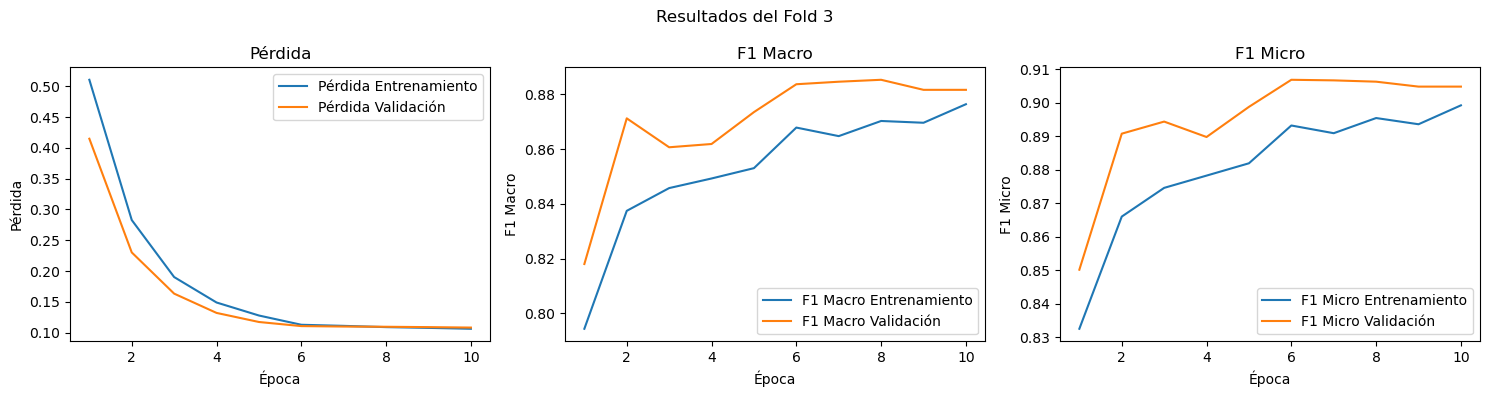


===== Fold 4 / 5 =====
Fase 1: Entrenamiento con base congelada
Epoch 1/5


2025-02-23 15:28:11,623 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 15:28:11,669 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 15:28:11,728 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 15:28:11,771 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 15:28:12,076 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-02-23 15:28:12,249 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 15:28:12,290 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 15:28:12,339 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 15:28:12,392 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 15:28:12,621 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-02-23 15:28:15,000 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 15:28:15,038 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 15:28:15,090 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 15:28:15,144 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 15:28:15,486 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-02-23 15:28:15,642 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 15:28:15,689 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 15:28:15,755 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 15:28:15,796 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 15:28:16,011 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


71/71 [==============================] - 184s 2s/step - loss: 0.5216 - f1_macro: 0.7932 - f1_micro: 0.8343 - val_loss: 0.3507 - val_f1_macro: 0.8353 - val_f1_micro: 0.8737
Epoch 2/5
71/71 [==============================] - 173s 2s/step - loss: 0.2737 - f1_macro: 0.8450 - f1_micro: 0.8735 - val_loss: 0.2143 - val_f1_macro: 0.8459 - val_f1_micro: 0.8739
Epoch 3/5
71/71 [==============================] - 172s 2s/step - loss: 0.1851 - f1_macro: 0.8536 - f1_micro: 0.8822 - val_loss: 0.1797 - val_f1_macro: 0.7975 - val_f1_micro: 0.8491
Epoch 4/5
71/71 [==============================] - 173s 2s/step - loss: 0.1424 - f1_macro: 0.8575 - f1_micro: 0.8879 - val_loss: 0.1372 - val_f1_macro: 0.8554 - val_f1_micro: 0.8810
Epoch 5/5
71/71 [==============================] - 171s 2s/step - loss: 0.1205 - f1_macro: 0.8593 - f1_micro: 0.8872 - val_loss: 0.1247 - val_f1_macro: 0.8324 - val_f1_micro: 0.8547
Fase 2: Fine-tuning descongelando las últimas 20 capas
Epoch 1/5


2025-02-23 15:42:46,656 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 15:42:46,708 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 15:42:46,778 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 15:42:46,817 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 15:42:47,188 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-02-23 15:42:47,358 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 15:42:47,413 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 15:42:47,470 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 15:42:47,510 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 15:42:47,777 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-02-23 15:42:50,667 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 15:42:50,712 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 15:42:50,773 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 15:42:50,825 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 15:42:51,174 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-02-23 15:42:51,339 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 15:42:51,380 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 15:42:51,427 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 15:42:51,482 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 15:42:51,705 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


71/71 [==============================] - 186s 2s/step - loss: 0.1068 - f1_macro: 0.8598 - f1_micro: 0.8878 - val_loss: 0.1129 - val_f1_macro: 0.8534 - val_f1_micro: 0.8819
Epoch 2/5
71/71 [==============================] - 175s 2s/step - loss: 0.1064 - f1_macro: 0.8727 - f1_micro: 0.8980 - val_loss: 0.1116 - val_f1_macro: 0.8590 - val_f1_micro: 0.8872
Epoch 3/5
71/71 [==============================] - 180s 3s/step - loss: 0.1046 - f1_macro: 0.8750 - f1_micro: 0.8999 - val_loss: 0.1107 - val_f1_macro: 0.8601 - val_f1_micro: 0.8886
Epoch 4/5
71/71 [==============================] - 181s 3s/step - loss: 0.1025 - f1_macro: 0.8782 - f1_micro: 0.9032 - val_loss: 0.1099 - val_f1_macro: 0.8586 - val_f1_micro: 0.8876
Epoch 5/5
71/71 [==============================] - 174s 2s/step - loss: 0.0993 - f1_macro: 0.8796 - f1_micro: 0.9030 - val_loss: 0.1093 - val_f1_macro: 0.8598 - val_f1_micro: 0.8882
Resultados fold 4: ['loss', 'f1_macro', 'f1_micro'] = [0.10930585116147995, 0.8598074316978455, 0.88

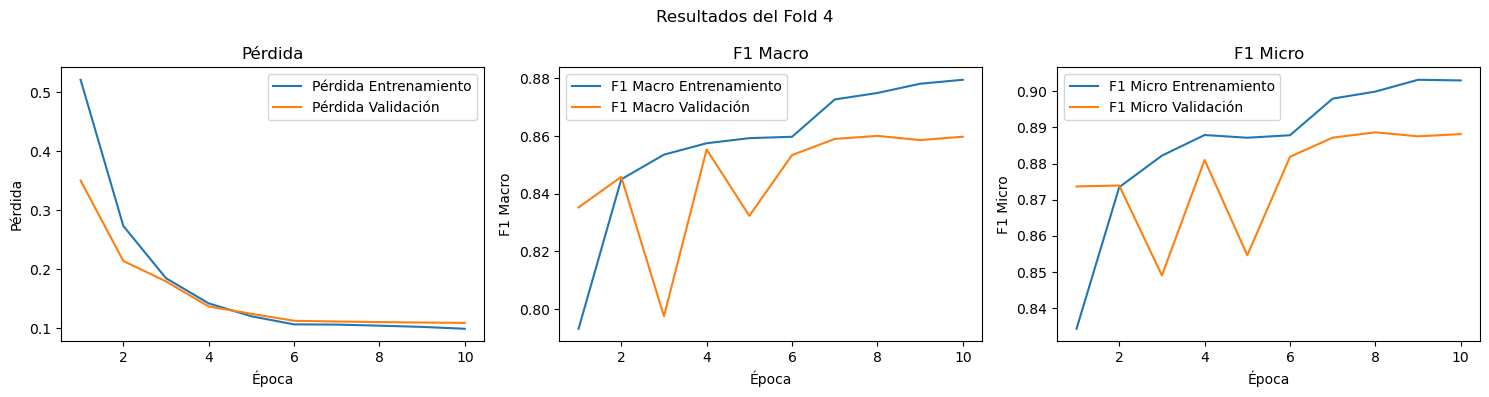


===== Fold 5 / 5 =====
Fase 1: Entrenamiento con base congelada
Epoch 1/5


2025-02-23 15:58:21,723 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 15:58:21,779 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 15:58:21,823 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 15:58:21,862 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 15:58:22,168 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-02-23 15:58:22,305 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 15:58:22,342 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 15:58:22,385 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 15:58:22,414 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 15:58:22,633 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-02-23 15:58:24,866 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 15:58:24,911 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 15:58:24,958 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 15:58:25,012 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 15:58:25,329 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-02-23 15:58:25,456 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 15:58:25,540 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 15:58:25,601 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 15:58:25,642 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 15:58:25,852 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


71/71 [==============================] - 182s 2s/step - loss: 0.5297 - f1_macro: 0.7867 - f1_micro: 0.8261 - val_loss: 0.3398 - val_f1_macro: 0.8829 - val_f1_micro: 0.8998
Epoch 2/5
71/71 [==============================] - 172s 2s/step - loss: 0.2612 - f1_macro: 0.8298 - f1_micro: 0.8659 - val_loss: 0.1932 - val_f1_macro: 0.8868 - val_f1_micro: 0.9022
Epoch 3/5
71/71 [==============================] - 175s 2s/step - loss: 0.1690 - f1_macro: 0.8549 - f1_micro: 0.8813 - val_loss: 0.1377 - val_f1_macro: 0.8784 - val_f1_micro: 0.9021
Epoch 4/5
71/71 [==============================] - 172s 2s/step - loss: 0.1338 - f1_macro: 0.8475 - f1_micro: 0.8785 - val_loss: 0.1164 - val_f1_macro: 0.8662 - val_f1_micro: 0.8894
Epoch 5/5
71/71 [==============================] - 172s 2s/step - loss: 0.1164 - f1_macro: 0.8436 - f1_micro: 0.8790 - val_loss: 0.1170 - val_f1_macro: 0.8746 - val_f1_micro: 0.8970
Fase 2: Fine-tuning descongelando las últimas 20 capas
Epoch 1/5


2025-02-23 16:12:56,714 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 16:12:56,763 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 16:12:56,836 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 16:12:56,885 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 16:12:57,250 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-02-23 16:12:57,427 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 16:12:57,484 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 16:12:57,546 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 16:12:57,612 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 16:12:57,938 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-02-23 16:13:01,384 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 16:13:01,441 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 16:13:01,514 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 16:13:01,573 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 16:13:02,064 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-02-23 16:13:02,266 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-23 16:13:02,320 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 16:13:02,401 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-23 16:13:02,471 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-23 16:13:02,816 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


71/71 [==============================] - 187s 2s/step - loss: 0.1080 - f1_macro: 0.8595 - f1_micro: 0.8873 - val_loss: 0.1040 - val_f1_macro: 0.8843 - val_f1_micro: 0.9036
Epoch 2/5
71/71 [==============================] - 176s 2s/step - loss: 0.1050 - f1_macro: 0.8585 - f1_micro: 0.8885 - val_loss: 0.1008 - val_f1_macro: 0.8875 - val_f1_micro: 0.9066
Epoch 3/5
71/71 [==============================] - 176s 2s/step - loss: 0.1011 - f1_macro: 0.8710 - f1_micro: 0.8964 - val_loss: 0.0989 - val_f1_macro: 0.8857 - val_f1_micro: 0.9056
Epoch 4/5
71/71 [==============================] - 175s 2s/step - loss: 0.1014 - f1_macro: 0.8687 - f1_micro: 0.8927 - val_loss: 0.0976 - val_f1_macro: 0.8854 - val_f1_micro: 0.9058
Epoch 5/5
71/71 [==============================] - 175s 2s/step - loss: 0.0997 - f1_macro: 0.8594 - f1_micro: 0.8902 - val_loss: 0.0968 - val_f1_macro: 0.8847 - val_f1_micro: 0.9047
Resultados fold 5: ['loss', 'f1_macro', 'f1_micro'] = [0.09683412313461304, 0.884723961353302, 0.904

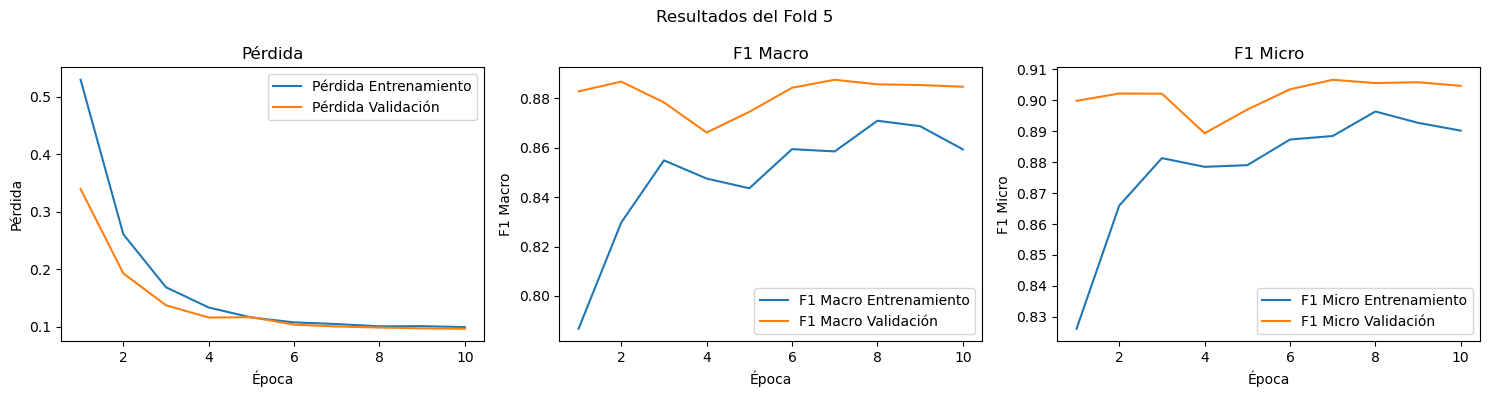


Proceso de K-Fold completado. El mejor modelo se guardó como 'mobilenetv3_classifier.v.11.keras'.


In [8]:
# K-fold cross validation
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# ---------------------------
# 1. Leer el CSV con los datos
# ---------------------------
csv_path = CSV_PATH_TEST 
df = pd.read_csv(csv_path)

# Se asume que el CSV tiene una columna "filename" y columnas de etiquetas "label1", "label2", "label3", "label4"
file_paths = df["filename"].values
labels = df[LABEL_COLUMNS].values.astype(np.float32)

print("Número de muestras:", len(file_paths))
print("Shape de etiquetas:", labels.shape)


# Parámetros
k_splits = 5
batch_size = BATCH_SIZE
initial_epochs = 5
finetune_epochs = 5   # Fase 2: fine-tuning (descongelar últimas 20 capas)
input_shape = TARGET_SIZE_CHANNEL
num_classes = len(LABEL_COLUMNS)

print('loss...')
loss_fn = tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0, alpha=alpha)
print('loss OK')

# Optimizador con learning rate adaptativo
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

num_classes = len(LABEL_COLUMNS)
# F1-score macro promedia la F1 de cada clase.
f1_macro = F1ScoreMacro(num_classes=num_classes, threshold=0.5)

# F1-score micro calcula la F1 global (acumulando TP, FP, FN de todas las clases).
f1_micro = F1ScoreMicro(threshold=0.5)


kf = KFold(n_splits=k_splits, shuffle=True, random_state=42)
fold_no = 1
best_val_loss = np.inf  # Para guardar el mejor modelo
final_model = None      # Para almacenar el modelo final
histories = []          # Para almacenar history de cada fold (opcional)

for train_idx, val_idx in kf.split(file_paths):
    print(f'\n===== Fold {fold_no} / {k_splits} =====')
    train_paths, train_labels = file_paths[train_idx], labels[train_idx]
    val_paths, val_labels = file_paths[val_idx], labels[val_idx]
    
    # Crear generadores
    train_gen = KFoldDataGenerator(train_paths, train_labels, batch_size=batch_size, shuffle=True)
    val_gen = KFoldDataGenerator(val_paths, val_labels, batch_size=batch_size, shuffle=False)
    
    # --- Fase 1: Entrenamiento con la base congelada ---
    model = build_model(num_classes=len(LABEL_COLUMNS))
    model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0, alpha=alpha),
        metrics=[f1_macro, f1_micro]
    )
    
    print("Fase 1: Entrenamiento con base congelada")
    history1 = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=initial_epochs,
        verbose=1
    )
    
    # --- Fase 2: Fine-Tuning ---
    # Descongelar las últimas 20 capas del modelo base
    base_model = model.get_layer('MobilenetV3large') # Índice de la capa MobileNetV3
    # En algunos casos, es mejor usar el nombre. Por ejemplo:
    # base_model = model.get_layer('mobilenetv3large')
    base_model.trainable = True
    for layer in base_model.layers[:-20]:
        layer.trainable = False
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0, alpha=alpha),
        metrics=[f1_macro, f1_micro]
    )
    
    print("Fase 2: Fine-tuning descongelando las últimas 20 capas")
    history2 = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=finetune_epochs,
        verbose=1
    )
    
    # Combinar histories (opcional, para graficar)
    history_combined = {}
    for key in history1.history.keys():
        history_combined[key] = history1.history[key] + history2.history[key]
    histories.append(history_combined)
    
    # Evaluar el modelo en el conjunto de validación
    scores = model.evaluate(val_gen, verbose=0)
    print(f"Resultados fold {fold_no}: {model.metrics_names} = {scores}")
    
    # Guardar el modelo si obtuvo menor pérdida de validación
    val_loss = scores[model.metrics_names.index('loss')]
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        final_model = model  # Se guarda el modelo con la mejor pérdida de validación
        model.save("mobilenetv3_classifier.v.11.keras")
        print(f"Nuevo mejor modelo guardado (fold {fold_no})")
    
    # Graficar la evolución de las métricas de este fold
    epochs_total = initial_epochs + finetune_epochs
    plt.figure(figsize=(15, 4))
    
    # Pérdida
    plt.subplot(1, 3, 1)
    plt.plot(range(1, epochs_total+1), history_combined['loss'], label='Pérdida Entrenamiento')
    plt.plot(range(1, epochs_total+1), history_combined['val_loss'], label='Pérdida Validación')
    plt.xlabel("Época")
    plt.ylabel("Pérdida")
    plt.title("Pérdida")
    plt.legend()
    
    # F1 Macro
    plt.subplot(1, 3, 2)
    plt.plot(range(1, epochs_total+1), history_combined['f1_macro'], label='F1 Macro Entrenamiento')
    plt.plot(range(1, epochs_total+1), history_combined['val_f1_macro'], label='F1 Macro Validación')
    plt.xlabel("Época")
    plt.ylabel("F1 Macro")
    plt.title("F1 Macro")
    plt.legend()
    
    # F1 Micro
    plt.subplot(1, 3, 3)
    plt.plot(range(1, epochs_total+1), history_combined['f1_micro'], label='F1 Micro Entrenamiento')
    plt.plot(range(1, epochs_total+1), history_combined['val_f1_micro'], label='F1 Micro Validación')
    plt.xlabel("Época")
    plt.ylabel("F1 Micro")
    plt.title("F1 Micro")
    plt.legend()
    
    plt.suptitle(f"Resultados del Fold {fold_no}")
    plt.tight_layout()
    plt.show()
    
    fold_no += 1

# Mostrar resultados promedio (por ejemplo, promedio de la pérdida de validación)
# (Aquí se puede agregar cálculo de promedios si se almacenan los scores de cada fold)
print("\nProceso de K-Fold completado. El mejor modelo se guardó como 'mobilenetv3_classifier.v.11.keras'.")


2025-02-24 10:31:24,278 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-24 10:31:24,316 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-24 10:31:24,357 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-24 10:31:24,391 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-24 10:31:24,874 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-02-24 10:31:25,025 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-02-24 10:31:25,068 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-24 10:31:25,285 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-02-24 10:31:25,339 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-02-24 10:31:25,606 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d_4   (None, 960)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 256)               2460

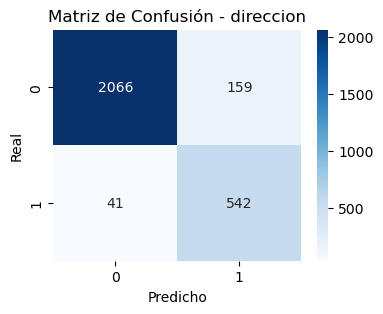

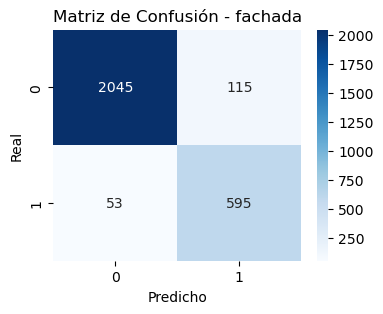

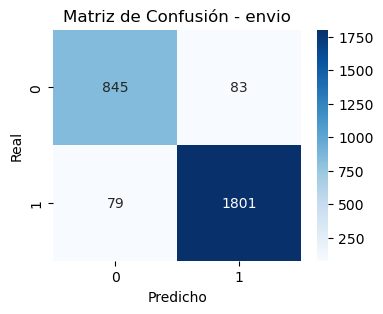

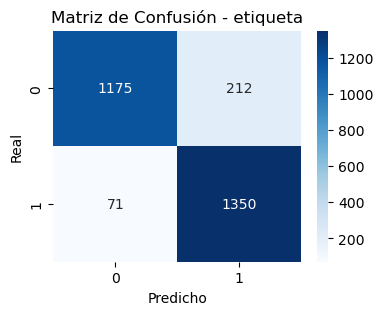

In [6]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.models import load_model

# Supongamos que tienes el conjunto de validación como un data generator
# y_true_total y y_pred_total se obtienen acumulando las etiquetas verdaderas y las predichas.

y_true_total = []
y_pred_total = []

val_df = pd.read_csv(CSV_PATH_TEST)
val_gen = CustomDataGenerator(val_df, BATCH_SIZE, TARGET_SIZE, LOCAL_IMAGE_PATH, label_columns=LABEL_COLUMNS, shuffle=False)
model = load_model('mobilenetv3_classifier.v.11.keras', 
                   custom_objects={
                       'F1ScoreMacro': lambda **kwargs: F1ScoreMacro(num_classes=len(LABEL_COLUMNS), threshold=0.5, **kwargs),
                       'F1ScoreMicro': lambda **kwargs: F1ScoreMicro(threshold=0.5, **kwargs)
    })
model.summary()

for i in range(len(val_gen)):
    X_batch, y_batch = val_gen[i]
    preds = model.predict(X_batch)
    y_true_total.append(y_batch)
    y_pred_total.append(preds)
    
    
print('generando...')
# Convertir a arrays
y_true_total = np.vstack(y_true_total)
y_pred_total = np.vstack(y_pred_total)

# Aplicar umbral para obtener predicciones binarias
threshold = 0.5
y_pred_binary = (y_pred_total > threshold).astype(int)

# Ahora, para cada clase, calculamos y graficamos la matriz de confusión
num_classes = y_true_total.shape[1]

for i in range(num_classes):
    cm = confusion_matrix(y_true_total[:, i], y_pred_binary[:, i])
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - {LABEL_COLUMNS[i]}')
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.show()


In [4]:
# 1. Cargar el modelo (agregando custom_objects si usas métricas personalizadas)
'''
model = tf.keras.models.load_model('mobilenetv3_classifier.v.11-ok.keras',
    custom_objects={
        'F1ScoreMacro': lambda **kwargs: F1ScoreMacro(num_classes=4, threshold=0.5, **kwargs),
        'F1ScoreMicro': lambda **kwargs: F1ScoreMicro(threshold=0.5, **kwargs)
    })

'''
model = tf.keras.models.load_model('mobilenetv3_classifier.v.11-rem.keras',
    custom_objects={
        'F1ScoreMacro': lambda **kwargs: F1ScoreMacro(num_classes=4, threshold=0.5, **kwargs),
        'F1ScoreMicro': lambda **kwargs: F1ScoreMicro(threshold=0.5, **kwargs)
    })


# 2. Función para cargar y preprocesar la imagen
# cargar las imagenes
def prepare_image(row, local_image_path, target_size=(224, 224)):
    try:
        # Cargar desde archivo local
        img_path = os.path.join(local_image_path, row['filename'])
        if os.path.exists(img_path):
            image = Image.open(img_path)
        elif pd.notna(row['urlAbsoluta']):    
             urlAbsoluta = row['urlAbsoluta']
             if 'http' in urlAbsoluta:
                 # Descargar la imagen desde la URL
                 response = requests.get(row['urlAbsoluta'], stream=True, timeout=10)
                 if response.status_code == 200:
                     image = Image.open(BytesIO(response.content))
                     #guardar local para el siguiente ciclo de entrenamiento/prueba
                     image.save(img_path)
             elif os.path.exists(urlAbsoluta):
                 image = Image.open(urlAbsoluta)
             else:
                 raise Exception(f'Error cargando {urlAbsoluta}, archivo no encontrado')
    
        # Convertir a RGB (en caso de que la imagen esté en otro formato, como RGBA)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        # Redimensionar la imagen
        image = image.resize(target_size)  # Redimensionar a 224x224 para MobileNetV3
        
        # Convertir a un array de numpy y normalizar
        image = np.array(image) / 255.0  # Normalizar

        image = np.expand_dims(image, axis=0)
        return image
    except BaseException as e:
        print(f'Error en: {img_path}, Excepción: {str(e)}')
        return None


# 3. Cargar una imagen real (ruta a la imagen)
image_path = "C:\Users\DIEGO\MobilNet\repo_validaton"  # Cambia a la ruta de la imagen que quieres probar
csv_validaton = '-\dataset_validacion_manual.csv'

df = pd.read_csv(csv_validaton)

for i in range(len(df)):
    print(f"Row {i}: {df.iloc[i]}")
    img_array = prepare_image(df.iloc[i], local_image_path=image_path)
    break

# 4. Realizar la predicción
predictions = model.predict(img_array)
print("Predicciones (probabilidades):", predictions)

# 5. Aplicar un umbral para obtener etiquetas binarias (para multi-etiqueta)
threshold = 0.5
pred_labels = (predictions > threshold).astype(int)
print("Etiquetas predichas:", pred_labels)


2025-03-03 17:54:48,545 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-03 17:54:48,591 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-03 17:54:48,643 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-03 17:54:48,685 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-03 17:54:49,090 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


2025-03-03 17:54:49,249 - WARNING - Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.


2025-03-03 17:54:49,303 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-03 17:54:49,352 - WARNING - Using a while_loop for converting Bitcast cause there is no registered converter for this op.


2025-03-03 17:54:49,393 - WARNING - Using a while_loop for converting StatelessRandomUniformV2 cause there is no registered converter for this op.


2025-03-03 17:54:49,668 - WARNING - Using a while_loop for converting ImageProjectiveTransformV3 cause there is no registered converter for this op.


FileNotFoundError: [Errno 2] No such file or directory: 'ruta/a/tu/imagen.jpg'